# Import requirements

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,

    AutoModelForSequenceClassification,
    AutoTokenizer
)

# 1. Preprocess

In [7]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [8]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [9]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [10]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [11]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [12]:
train_pos[:10]

['0 40881 15381 6 5 2',
 '0 133924 43373 4516 6 5 2',
 '0 1836 2843 765 31815 5361 7 136 6 2980 24709 3129 83 6183 4127 6 5 2',
 '0 442 242 7 10 4127 47 11 14437 23233 16857 6 5 2',
 '0 70 23082 83 101786 6 5 2',
 '0 4127 1909 15381 6 5 2',
 '0 4127 4516 6 5 2',
 '0 101084 111 5155 83 44277 2873 136 71358 111 5361 7 6 5 2',
 '0 6782 3687 100 40781 707 1909 69881 7 136 115393 6 5 2',
 '0 70 3525 37457 33342 44613 6 5 2']

In [13]:
train_neg[:10]

['0 17 509 17110 538 121742 19 6 5 2',
 '0 221 98 47 70 23233 124308 6 4 70 111880 83 4537 11675 111 70 48137 6 5 2',
 '0 20187 163 257 136 10 8721 111 7547 107 69819 9993 49036 6 5 2',
 '0 33720 6183 5361 619 959 41965 53 111 70 3650 101 2606 454 27167 7909 6 5 2',
 '0 17932 6 4 70 2288 344 23233 16857 6 4 442 83 10 2955 60744 6 5 2',
 '0 17 1902 47 8783 3650 101 2606 454 47 15190 96967 47 70 23233 16857 6 5 2',
 '0 2412 30745 163 2685 509 10 25534 100 70 184897 98 70 5609 6 5 2',
 '0 621 398 200 59725 163 705 2',
 '0 17 509 959 7730 47 8783 100 70 184897 98 70 5609 6 5 2',
 '0 17 12989 297 442 15490 9993 49036 6 4 168390 6 4 98 17514 6 4 707 184897 6 5 2']

In [14]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [15]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [16]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    0, 40881, 15381,     6,     5,     2]), array([1]))
(array([     0, 133924,  43373,   4516,      6,      5,      2]), array([1]))
(array([    0,  1836,  2843,   765, 31815,  5361,     7,   136,     6,
        2980, 24709,  3129,    83,  6183,  4127,     6,     5,     2]), array([1]))
(array([    0,   442,   242,     7,    10,  4127,    47,    11, 14437,
       23233, 16857,     6,     5,     2]), array([1]))
(array([     0,     70,  23082,     83, 101786,      6,      5,      2]), array([1]))
(array([    0,  4127,  1909, 15381,     6,     5,     2]), array([1]))
(array([   0, 4127, 4516,    6,    5,    2]), array([1]))
(array([     0, 101084,    111,   5155,     83,  44277,   2873,    136,
        71358,    111,   5361,      7,      6,      5,      2]), array([1]))
(array([     0,   6782,   3687,    100,  40781,    707,   1909,  69881,
            7,    136, 115393,      6,      5,      2]), array([1]))
(array([    0,    70,  3525, 37457, 33342, 44613,     6,     5,     2])

In [17]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [18]:
train_batch_size=256 #batch size -> 32 to 128
eval_batch_size=128 #batch size -> 64 to 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, #shuffle false -> true
                                         num_workers=2)

In [19]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base')
model.to(device)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [20]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [22]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [23]:
train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###



            if iteration != 0 and iteration % int(len(train_loader) / 20) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###


                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss

Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.19it/s]
                                                     

Acc for model which have lower valid loss:  0.547


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.72it/s]
                                                     

Acc for model which have lower valid loss:  0.8995


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]
                                                     

Acc for model which have lower valid loss:  0.9465


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.35it/s]
                                                     

Acc for model which have lower valid loss:  0.95425


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]
                                                     

Acc for model which have lower valid loss:  0.962


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.66it/s]
                                                     

Acc for model which have lower valid loss:  0.96175


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.50it/s]
                                                     

Acc for model which have lower valid loss:  0.96825


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.54it/s]
                                                     

Acc for model which have lower valid loss:  0.96825


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.77it/s]
                                                     

Acc for model which have lower valid loss:  0.96925


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.59it/s]
                                                     

Acc for model which have lower valid loss:  0.9705


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.56it/s]
                                                     

Acc for model which have lower valid loss:  0.97125


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.63it/s]
                                                     

Acc for model which have lower valid loss:  0.974


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.55it/s]
                                                     

Acc for model which have lower valid loss:  0.97675


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.83it/s]
                                                     

Acc for model which have lower valid loss:  0.97625


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.61it/s]
                                                     

Acc for model which have lower valid loss:  0.97675


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.70it/s]
                                                     

Acc for model which have lower valid loss:  0.97675


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.66it/s]
                                                     

Acc for model which have lower valid loss:  0.97625


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.63it/s]
                                                     

Acc for model which have lower valid loss:  0.97775


Epoch 2: 100%|██████████| 1732/1732 [32:26<00:00,  1.12s/batch, loss=0.0262]


In [24]:
endtime = time.time()

In [25]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [26]:
test_dataset = test_df['Id']

In [27]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [28]:
test = make_id_file_test(tokenizer, test_dataset)

In [29]:
test[:10]

['0 442 242 7 10 28271 3525 16981 136 3525 196634 7 12638 1733 398 738 6 5 2',
 '0 221 2837 140545 214 1295 142 10332 40304 6 5 2',
 '0 442 83 70 2684 195734 6404 23 70 118666 53 6 5 2',
 '0 54 959 24092 10 95 6991 678 6097 3395 6 5 2',
 '0 17 509 11066 13048 136 2412 7228 163 12319 221 104577 136 81907 6 5 2',
 '0 70 4734 13580 642 75204 450 509 8010 509 70 79497 6 5 2',
 '0 110 6 4 959 70 64333 99 26041 6 4 70 64333 23 48807 11192 6 5 2',
 '0 1836 19095 442 1810 12912 100 398 136 621 4552 98893 6 5 2',
 '0 1001 70 115 112 6777 653 25 18 3853 3714 3642 47 4488 70 13909 6 5 2',
 '0 1836 765 142 40881 132216 111 375 16091 47 55076 1295 6 5 2']

In [30]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [31]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [32]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [33]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [34]:
with torch.no_grad():
    model.eval()
    predictions = []
    ex0 = []
    ex1 = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        ex0 += [example[0].cpu().numpy() for example in logits]
        ex1 += [example[1].cpu().numpy() for example in logits]
        predictions += batch_predictions


Test:  12%|█▎        | 4/32 [00:00<00:01, 15.68it/s]

tensor([[-4.2387,  4.6156],
        [ 3.5437, -3.8244],
        [-4.2612,  4.5964],
        [ 4.3022, -4.7879],
        [-4.3108,  4.6808],
        [ 4.3140, -4.7921],
        [ 4.1027, -4.4758],
        [-4.3020,  4.7036],
        [ 4.1343, -4.5241],
        [-4.2543,  4.6047],
        [-4.1360,  4.6177],
        [ 4.4876, -4.9585],
        [ 3.3317, -3.5997],
        [-4.2958,  4.6938],
        [-4.2646,  4.6103],
        [ 4.3701, -4.8618],
        [-1.9945,  2.3368],
        [-4.2751,  4.6279],
        [ 4.1562, -4.6380],
        [ 4.3526, -4.8166],
        [ 2.6847, -2.9091],
        [-4.2027,  4.6021],
        [ 2.2875, -2.3634],
        [-4.2908,  4.6947],
        [ 3.9248, -4.2479],
        [ 2.1612, -2.3253],
        [-4.2702,  4.6349],
        [-3.6340,  4.0392],
        [ 2.3150, -2.5102],
        [ 4.1291, -4.6243],
        [ 3.6610, -3.9107],
        [ 4.0383, -4.4421]], device='cuda:0')
tensor([[ 4.2111, -4.5890],
        [ 4.3439, -4.8554],
        [ 4.2375, -4.7338],
  


Test:  31%|███▏      | 10/32 [00:00<00:01, 20.14it/s]

tensor([[-4.2987,  4.7109],
        [ 4.2806, -4.7933],
        [-4.2883,  4.6238],
        [ 3.9380, -4.3738],
        [-4.2023,  4.5283],
        [ 4.2606, -4.7188],
        [ 4.3052, -4.8324],
        [-4.2694,  4.7142],
        [ 4.2548, -4.7630],
        [-3.1193,  3.5287],
        [-3.4188,  3.8267],
        [ 3.7323, -4.1006],
        [-4.1771,  4.5277],
        [-4.2747,  4.7131],
        [ 4.3254, -4.8888],
        [-4.3049,  4.7321],
        [-4.2911,  4.6675],
        [-4.2457,  4.5916],
        [-4.3014,  4.6792],
        [ 3.0535, -3.3447],
        [ 4.2234, -4.7526],
        [ 3.9489, -4.3948],
        [ 4.0801, -4.4975],
        [ 4.2777, -4.7016],
        [ 3.7442, -4.1519],
        [-4.2991,  4.7084],
        [-4.1214,  4.5141],
        [-2.8895,  3.3048],
        [-3.8708,  4.2689],
        [-4.2982,  4.7109],
        [ 3.8358, -4.2141],
        [ 2.7322, -2.9035]], device='cuda:0')
tensor([[-4.2415,  4.6789],
        [ 4.2589, -4.7703],
        [ 3.5879, -3.9704],
  


Test:  41%|████      | 13/32 [00:00<00:00, 21.21it/s]

tensor([[ 4.0085, -4.3836],
        [-4.2930,  4.6764],
        [-4.2995,  4.6902],
        [ 0.3148, -0.1194],
        [ 4.0924, -4.5787],
        [ 2.1524, -2.1641],
        [ 3.1185, -3.4135],
        [-4.2855,  4.6543],
        [-4.2858,  4.7068],
        [-4.3013,  4.7321],
        [ 4.3099, -4.8010],
        [-4.2448,  4.5995],
        [-4.1799,  4.5139],
        [-4.3169,  4.7020],
        [-4.2851,  4.6871],
        [-4.2680,  4.7186],
        [-4.2794,  4.7200],
        [-2.4375,  2.8316],
        [-4.2945,  4.7217],
        [-4.2724,  4.7215],
        [-4.2735,  4.6351],
        [-4.2804,  4.6571],
        [-4.3065,  4.7186],
        [-4.1123,  4.5366],
        [-4.2775,  4.6778],
        [ 4.2792, -4.7520],
        [-1.3959,  1.8100],
        [ 0.9648, -0.9007],
        [-1.1547,  1.5340],
        [ 4.2780, -4.7741],
        [ 4.2738, -4.7821],
        [-0.1379,  0.3793]], device='cuda:0')
tensor([[ 4.2451, -4.6810],
        [-4.1075,  4.4838],
        [-4.3046,  4.7100],
  


Test:  59%|█████▉    | 19/32 [00:00<00:00, 22.50it/s]

tensor([[-4.2570,  4.6193],
        [-4.2917,  4.7245],
        [-4.2864,  4.6778],
        [-4.2918,  4.6893],
        [-4.1486,  4.5034],
        [-3.4800,  3.9074],
        [-4.2734,  4.6154],
        [-4.2922,  4.6888],
        [ 3.9265, -4.2437],
        [ 2.8436, -3.0483],
        [ 4.2362, -4.6902],
        [ 3.8367, -4.2300],
        [-4.1740,  4.5409],
        [-4.3052,  4.7103],
        [-2.8432,  3.2515],
        [ 2.6354, -2.7466],
        [-4.3008,  4.7138],
        [ 4.2834, -4.6951],
        [ 4.1022, -4.5459],
        [-3.4664,  3.8334],
        [ 4.2338, -4.7748],
        [ 1.7505, -1.7299],
        [ 4.2712, -4.6424],
        [ 1.3225, -1.1972],
        [ 0.1366,  0.1042],
        [ 4.2410, -4.7668],
        [ 4.1808, -4.6387],
        [ 3.0926, -3.3270],
        [ 2.7533, -2.9520],
        [ 3.8634, -4.1350],
        [ 3.6966, -3.9812],
        [-4.2912,  4.7105]], device='cuda:0')
tensor([[-4.2988,  4.6742],
        [ 4.0305, -4.4613],
        [ 3.7104, -4.1157],
  


Test:  78%|███████▊  | 25/32 [00:01<00:00, 22.73it/s]

tensor([[ 3.7509, -4.1937],
        [-3.6951,  4.0351],
        [ 3.3222, -3.6022],
        [ 4.2777, -4.7431],
        [ 4.0186, -4.4834],
        [ 4.1222, -4.5576],
        [-4.2927,  4.6604],
        [ 3.6967, -4.0600],
        [-3.3357,  3.6728],
        [ 2.9070, -3.1282],
        [-4.2949,  4.7199],
        [ 1.1288, -1.0291],
        [ 3.9436, -4.2808],
        [-4.2906,  4.6839],
        [ 4.2977, -4.7713],
        [-0.4658,  0.7371],
        [-4.3036,  4.7148],
        [-4.2839,  4.6764],
        [-4.1976,  4.5872],
        [ 3.5433, -3.8548],
        [-4.1678,  4.5865],
        [ 3.9942, -4.3157],
        [ 4.2334, -4.7506],
        [ 4.2983, -4.8267],
        [-4.2897,  4.6970],
        [ 4.2307, -4.7218],
        [ 4.3179, -4.8253],
        [ 4.3045, -4.8090],
        [ 4.3475, -4.8691],
        [-3.5244,  3.9485],
        [ 2.9385, -3.2238],
        [ 3.6931, -4.0120]], device='cuda:0')
tensor([[ 4.2969, -4.7575],
        [ 4.3351, -4.8412],
        [ 4.2423, -4.7486],
  


Test:  88%|████████▊ | 28/32 [00:01<00:00, 22.89it/s]

tensor([[-4.2838,  4.6573],
        [ 2.9202, -3.1611],
        [-3.7818,  4.1876],
        [ 3.5696, -3.8639],
        [ 4.3051, -4.8198],
        [-4.2447,  4.6058],
        [ 4.0692, -4.4601],
        [ 3.7232, -4.0572],
        [-2.5798,  3.0217],
        [ 3.9501, -4.4245],
        [-4.2976,  4.6889],
        [-4.2223,  4.5251],
        [ 2.7388, -2.9643],
        [-4.2656,  4.6305],
        [-4.2520,  4.6064],
        [ 4.3403, -4.8623],
        [-4.2332,  4.6328],
        [ 2.9975, -3.1908],
        [ 4.3188, -4.7479],
        [-4.2228,  4.6244],
        [-4.2945,  4.7193],
        [-4.2642,  4.5854],
        [-4.2709,  4.6393],
        [-4.2788,  4.6440],
        [-3.2114,  3.6771],
        [-4.2657,  4.6262],
        [-4.2744,  4.6517],
        [-4.2845,  4.6579],
        [-4.2478,  4.6143],
        [ 3.3227, -3.6118],
        [-4.0883,  4.4740],
        [ 4.1978, -4.6132]], device='cuda:0')
tensor([[-4.2504,  4.5802],
        [ 1.1987, -1.1408],
        [ 1.1105, -1.0271],
  


Test:  97%|█████████▋| 31/32 [00:01<00:00, 22.73it/s]
                                                     

tensor([[-4.3122,  4.7184],
        [-4.2809,  4.6729],
        [ 0.5161, -0.2494],
        [-3.4223,  3.8263],
        [-4.3154,  4.7191],
        [-1.9921,  2.3607],
        [-4.2527,  4.5827],
        [ 4.2849, -4.7926],
        [ 4.2782, -4.7074],
        [ 4.3664, -4.8677],
        [ 3.1569, -3.4087],
        [-4.1758,  4.5370],
        [ 3.8907, -4.1957],
        [-4.2971,  4.6705],
        [-4.2672,  4.6299],
        [ 3.3607, -3.6634],
        [ 4.3805, -4.8516],
        [ 3.7837, -4.1742],
        [-4.1401,  4.6226],
        [ 3.2408, -3.5888],
        [-4.0074,  4.4650],
        [-4.0888,  4.5006],
        [-4.0553,  4.4228],
        [-4.2959,  4.6964],
        [ 3.6077, -3.9612],
        [ 4.3331, -4.8177],
        [-4.2561,  4.6180],
        [ 3.9227, -4.3141],
        [ 4.4305, -4.8871],
        [ 4.2501, -4.7387],
        [-4.2260,  4.5609],
        [-4.2973,  4.7196]], device='cuda:0')
tensor([[ 4.2695, -4.7825],
        [ 4.0422, -4.4643],
        [-4.2203,  4.5833],
  

In [35]:
test_df['Category'] = predictions

In [36]:
test_df.to_csv('submission_roberta_base_uncased.csv', index=False)

In [37]:
test_df['ex0'] = ex0
test_df['ex1'] = ex1
test_df.to_csv('roberta_base_uncased_softvoting.csv', index=False)

In [38]:
print(lowest_valid_loss)

0.058966429613064975


In [39]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118, 1204, 1290, 1376, 1462, 1548, 1634, 1720, 86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118, 1204, 1290, 1376, 1462, 1548, 1634, 1720, 86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118, 1204, 1290, 1376, 1462, 1548, 1634, 1720]
[0.547, 0.8995, 0.9465, 0.95425, 0.962, 0.96175, 0.96325, 0.96825, 0.9595, 0.96825, 0.96925, 0.9705, 0.973, 0.97125, 0.974, 0.96975, 0.97, 0.97675, 0.97625, 0.976, 0.9725, 0.9775, 0.975, 0.97425, 0.9755, 0.975, 0.97475, 0.97675, 0.97675, 0.9745, 0.9765, 0.96775, 0.969, 0.97625, 0.9785, 0.9775, 0.978, 0.97775, 0.97875, 0.97775, 0.9735, 0.97675, 0.97275, 0.97875, 0.9775, 0.97, 0.976, 0.9775, 0.9755, 0.97675, 0.97875, 0.97675, 0.9745, 0.97675, 0.97775, 0.97825, 0.97225, 0.9755, 0.97875, 0.979]
[0.7619196362793446, 0.2536179553717375, 0.15098489739466459, 0.11851346329785883, 0.10879202513024211, 0.10552214575000107, 0.10587611445225775, 0.08972779777832329, 0.1080634656

In [40]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118, 1204, 1290, 1376, 1462, 1548, 1634, 1720, 1817, 1903, 1989, 2075, 2161, 2247, 2333, 2419, 2505, 2591, 2677, 2763, 2849, 2935, 3021, 3107, 3193, 3279, 3365, 3451, 3548, 3634, 3720, 3806, 3892, 3978, 4064, 4150, 4236, 4322, 4408, 4494, 4580, 4666, 4752, 4838, 4924, 5010, 5096, 5182]


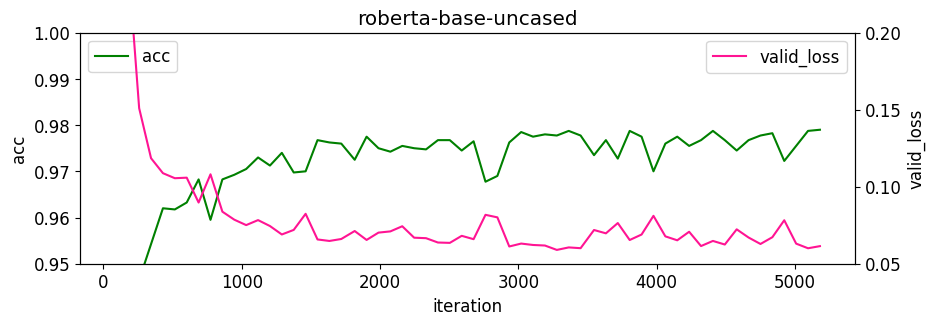

In [41]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper left')
ax1.set_ylim([0.950,1])

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0.05,0.2])

plt.title("roberta-base-uncased")

plt.show()

In [42]:
print(endtime - starttime)

5883.869087219238
